In [1]:
from Image_Process import *
from scipy.ndimage import rotate

In [2]:
mrc_dir_path = '/central/scratch/hmmai_jensen_montage/data/MontTS/1.75umBeam/'
mask_dir = '/central/scratch/hmmai_jensen_montage/processing/1.75umBeam/masks/'
norm_npy_dir = '/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/'
stitched_dir = '/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/test_stitched/'

In [3]:
pixel_size = 4.5160003
beam_diameter = 1.75 #um
# beam_centers = '0.0 0.0 -1.425357 -0.251329 -0.930335 1.108731 0.495021 1.360059 1.425357 0.251329 0.930335 -1.108731 -0.495021 -1.360059 -1.920378 -1.611388 -2.850713 -0.502658 -2.355692 0.857402 -1.860671 2.217461 -0.435314 2.46879 0.990042 2.720119 1.920378 1.611388 2.850713 0.502658 2.355692 -0.857402 1.860671 -2.217461 0.435314 -2.46879 -0.990042 -2.720119 -2.415399 -2.971448 -3.345734 -1.862717 -4.27607 -0.753986 -3.781048 0.606073 -3.286027 1.966132 -2.791006 3.326192 -1.36565 3.57752 0.059707 3.828849 1.485063 4.080178 2.415399 2.971448 3.345734 1.862717 4.27607 0.753986 3.781048 -0.606073 3.286027 -1.966132 2.791006 -3.326192 1.36565 -3.57752 -0.059707 -3.828849 -1.485063 -4.080178'
# beam_centers = beam_centers.split()
# beam_centers = np.array(beam_centers, dtype=float).reshape(-1,2)
# beam_centers *= 1e4/pixel_size
# # np.save('beam_centers_p.npy',beam_centers) 

beam_centers = np.load('beam_centers_p.npy',mmap_mode='r') #this file is already in unit of pixels

In [4]:
theta=np.radians(186)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

In [5]:
# centers = beam_centers[:4:3,:].copy()
centers = beam_centers[:3,:].copy()
centers = centers.dot(R)
centers = centers[:,::-1]
centers = np.array(centers, dtype=int)
centers

array([[    0,     0],
       [  223,  3197],
       [-2657,  1792]])

In [ ]:
#my manual found initial guesses was
# centers = np.array([[-231, 126],
#                     [2980, 350],
#                     [1550, -2550]])

In [6]:
# #Distances
# for i in range(1, centers.shape[0]):
#     intended_dist = np.sqrt(sum((beam_centers[i,:]-beam_centers[0,:])**2))
#     print(f'Intended tile {i} and 0 dist={intended_dist} pixels')
#     now_dist = np.sqrt(sum((centers[i,:]-centers[0,:])**2))
#     print(f'Now tile {i} and 0 dist={now_dist} pixels')

Intended tile 1 and 0 dist=3204.927724649449 pixels
Now tile 1 and 0 dist=3204.768010324616 pixels
Intended tile 2 and 0 dist=3204.926805841971 pixels
Now tile 2 and 0 dist=3204.8265163655897 pixels
Intended tile 3 and 0 dist=3204.925758855945 pixels
Now tile 3 and 0 dist=3204.0 pixels


In [6]:
pair_path = 'test_pairs.npy'
c_path = 'test_centers0.npy'

initial_guesses = centers.copy()
beam_diameter=1.75

pairs = get_pairs(centers, beam_diameter*1e4/pixel_size)
np.save(pair_path, pairs)
np.save(c_path, initial_guesses)

In [8]:
# TODO
# iterative : if opt_c too close to boundary (<3 pixels), do a second iteration? or smaller search
# if opt_c correspond to normalized cc < 0.2, do a second interation 
# by second iteration, still doesn't work, then mark as failure?

In [7]:
n_processes = 4
print(f'num processes:{n_processes}') 

bound_p = 20
pixel_size = 4.5160003
print(f'searching +/- {bound_p*pixel_size/10} nm from initial guesses')

start_time=time.time()
opt_c, cmat, nmat = opt_CC_greedy(norm_npy_dir, pair_path, c_path, mask_dir, bound_p, 0,
                                  debug=True, n_processes=n_processes)
print(f'time: {time.time() - start_time}s')
print('displacement by')
print(opt_c[1:,:] - initial_guesses[1:,:])
print('Initial guesses')
print(initial_guesses)
print('Optimized centers')
print(opt_c)

num processes:4
searching +/- 9.0320006 nm from initial guesses
greedy at tile 1 with relevant pairs [memmap([0, 1])]
center 1 mat_ijs=[[19 35]]
mean perturbed mat_i=19.0 mat_j=35.0
greedy at tile 2 with relevant pairs [memmap([0, 2]), memmap([1, 2])]
center 2 mat_ijs=[[ 0 11]
 [ 0  9]]
mean perturbed mat_i=0.0 mat_j=10.0
time: 613.6773846149445s
displacement by
[[ -1  15]
 [-20 -10]]
Initial guesses
[[    0     0]
 [  223  3197]
 [-2657  1792]]
Optimized centers
[[    0     0]
 [  222  3212]
 [-2677  1782]]


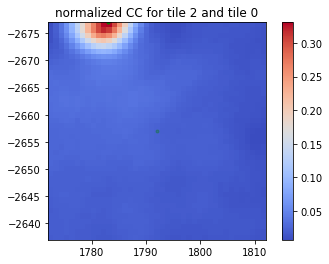

In [8]:
TOI = 2 #Tile of Interest
mean= False #Plot mean CC matrix for the tile of interest or not

#Only needed when mean=False to plot individual CC matrix of pair(TOI, slic)
slic = 0
mods = np.array([[0, 11],
                 [ 0, 9]], dtype=int) - bound_p

plt.figure()
if mean: norm_c = (np.array(cmat[TOI-1])/np.array(nmat[TOI-1])).mean(axis=0)
else: norm_c = (np.array(cmat[TOI-1])/np.array(nmat[TOI-1]))[slic,:,:]
plt.imshow(norm_c, cmap='coolwarm', extent=[initial_guesses[TOI,1]-bound_p,
                                            initial_guesses[TOI,1]+bound_p,
                                            initial_guesses[TOI,0]+bound_p,
                                            initial_guesses[TOI,0]-bound_p])
plt.plot(initial_guesses[TOI,1], initial_guesses[TOI,0],'go', alpha=0.3,markersize=3)
if mean: 
    plt.plot(opt_c[TOI,1], opt_c[TOI,0],'go', markersize=3)
    plt.title(f'mean normalized CC for tile {TOI}')
else: 
    plt.plot(initial_guesses[TOI,1]+mods[slic,1], initial_guesses[TOI,0]+mods[slic,0],
             'go', markersize=3)
    plt.title(f'normalized CC for tile {TOI} and tile {slic}')

# plt.clim(-1,1)
plt.colorbar()

[ 8389 10766]
before centering canvas: [[    0     0]
 [  222  3212]
 [-2677  1782]]
after centering canvas: [[5012 3718]
 [5234 6930]
 [2335 5500]]


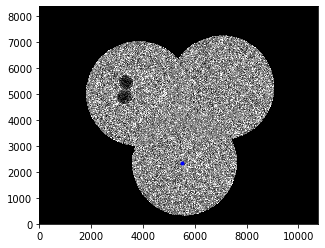

In [9]:
stitched = stitch(opt_c.copy(), tile_shape=(4092, 5760), im_path=mrc_dir_path, tile_inds=[0,1,2],
                  mask_dir=mask_dir, tilt_angle=0)

In [10]:
save_mrc(stitched, stitched_dir+'opt012.mrc')

#### Normalize tiles by taking the mean and std of all tiles for ONE tilt angle

In [14]:
import glob
def get_mean_of_tilt(mrc_dir, tilt_angle):
    p_counts = 0
    I_tot = 0
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        beam = np.array(mask, dtype=bool)
        p_counts += mask.sum()
        I_tot += tile[beam].sum()
    return I_tot/p_counts

def get_std_of_tilt(mrc_dir, tilt_angle, mu):
    p_counts = 0
    var_tot = 0
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        beam = np.array(mask, dtype=bool)
        p_counts += mask.sum()
        var_tot += sum((tile[beam]-mu)**2)
    return np.sqrt(var_tot/(p_counts-1))

def process_tiles_of_tilt(mrc_dir, tilt_angle, out_dir, mu, std):
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        corner = np.array(1-mask, dtype=bool)
        tile[corner] = 0
        tile = ma.masked_array(tile, corner)
        tile = preprocess(tile, mu, std)
        save_mrc(tile.data, out_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.mrc')
#         np.save(out_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', tile.data)
        print(f'Tile {tile_ind} mean: {tile.mean()} std: {tile.std()}')

In [6]:
mu = get_mean_of_tilt(mrc_dir_path, 0)
print(mu)

379.8169817989392

In [7]:
std = get_std_of_tilt(mrc_dir_path, 0, mu)
print(std)

107.76934237428094

In [16]:
out_dir='/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/'
process_tiles_of_tilt(mrc_dir_path, 0, out_dir, mu, std)

Tile 13 mean: 0.006642712242225475 std: 0.9962220608310278
Tile 14 mean: 0.01665145937364819 std: 0.9944493892321598
Tile 16 mean: 0.012714617756898725 std: 0.9893000287020405
Tile 33 mean: -0.01533779993754953 std: 0.9790464213120321
Tile 0 mean: -0.02897014118556019 std: 1.052139007286906
Tile 24 mean: -0.013090686127867943 std: 1.00688421413913
Tile 18 mean: 0.010032372471010853 std: 0.9937846529652203
Tile 26 mean: -0.07637184349836451 std: 1.0406870343989207
Tile 17 mean: 0.013776346713024948 std: 0.9968514903712261
Tile 6 mean: 0.01768923816026488 std: 1.0007421460024444
Tile 11 mean: 0.014989891051912224 std: 0.9985178317027339
Tile 4 mean: 0.017725579151835605 std: 0.9949585771853364
Tile 20 mean: -0.013314818379036754 std: 1.0113018404470042
Tile 5 mean: 0.012107354342396811 std: 0.989889397581144
Tile 12 mean: 0.011765169070018731 std: 1.0026082755488313
Tile 31 mean: 0.004414853877996295 std: 0.9839274697257991
Tile 32 mean: 0.0009796907736489644 std: 0.9817809468202666
Tile

In [20]:
# I previously stored normalized tiles as .npy, this code is to correct them to .mrc
# for npy_file in glob.glob(norm_npy_dir+f'*.npy'):
#     norm_tile = np.load(npy_file, mmap_mode='r')
#     save_mrc(norm_tile, npy_file[:-3]+'mrc')

In [ ]:
# obsolete code used to compare beam input and mrc headers
# with open('tilts_centers.txt','w') as f_centers:
#     with open('montage1.txt', 'r') as f_beam:
#         for line in f_beam:
#             tilt_angle = line.split()[0]
#             print(f'TiltAngle: {tilt_angle}')
#             f_centers.write(f'TiltAngle: {tilt_angle}\n')

#             beam_centers = line.split()[1:]
#             beam_centers = np.array(beam_centers, dtype=float).reshape(-1,2)
#             for i in range(beam_centers.shape[0]):
#                 with open(mrc_dir_path+f'Xgrating2_{tilt_angle}_{i}.mrc.mdoc', 'r') as f_mrc:
#                     for line in f_mrc:
#                         if 'ImageShift' in line: 
#                             f_centers.write(f'Tile {i}: Beamcenter={beam_centers[i,:]}\n')
#                             im_shift = np.array(line.split('=')[1].split(), dtype=float)
#                             f_centers.write(f'Tile {i}: ImageShift={im_shift}\n')
#             f_centers.write('\n')